# Baseline KNN on spectra

## Settings

In [1]:
base = "data"
dataset = "nist"
kind = "in_database"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"

max_mz = 1001

%load_ext autoreload
%autoreload 2

In [2]:
# compounds to visualize 
if kind == "in_database":
    interesting =  ["Atrazine", "Carbofuran", "Monocrotophos", "Mevinphos", "Testosterone"]
elif kind == "de_novo":
    interesting =  ["Metobromuron", "Picoxystrobin", "Cyphenothrin", "Mirex"]

## Data loading

In [3]:
from matchms.importing import load_from_msp
from data_utils import spectrum_processing, get_n_samples, FixedSizeDS, TopKDS
from helpers import get_mz_vector, get_his_size, compact_to_mz
import numpy as np
from scipy.sparse import csr_matrix

# only for visual 
from spec2vec import SpectrumDocument
from data_utils import BasicCoder

In [4]:
def get_spectra(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s, min_rel_int=None) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    return spectrums
spectrums_train = get_spectra(data_train_path)
spectrums_val = get_spectra(data_val_path)
spectrums_test = get_spectra(data_test_path)

In [5]:
documents_test = [SpectrumDocument(s, n_decimals=0) for s in spectrums_test]

In [6]:
datasets = {
    "spec_train": spectrums_train, 
    "spec_val": spectrums_val, 
    "spec_val_5000": get_n_samples(spectrums_val, 5000),
    "spec_val_10000": get_n_samples(spectrums_val, 10000),
    "spec_test": spectrums_test, 
    "fixed_test": FixedSizeDS(spectrums_test)
}


In [7]:
mz_matrix_train = np.zeros(shape=(len(spectrums_train), max_mz))
for i, spec in enumerate(spectrums_train):
    mz_matrix_train[i] = get_mz_vector(spec, max_mz)

In [8]:
def get_weighted(matrix):
    n_sam =matrix.shape[0] 
    n_mz = matrix.shape[1]
    factors = np.tile(np.arange(n_mz), n_sam).reshape(n_sam, -1) + 1
    return (matrix**0.5) * factors

weighted_cosine_mz_matrix = get_weighted(mz_matrix_train)

In [9]:
sparse_weighted_mz_matrix = csr_matrix(weighted_cosine_mz_matrix)
sparse_mz_matrix = csr_matrix(mz_matrix_train)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy.random import default_rng
from sklearn.neighbors import NearestNeighbors


class BasePredictorKNN():
    def __init__(self, dense_matrix, weighted_cosine_mz_matrix, cosine_mz_matrix, n=10, \
                 max_mz=1001, above_fraction=0.5):
        self.weighted_cosine_mz_matrix = weighted_cosine_mz_matrix
        self.cosine_mz_matrix = cosine_mz_matrix
        self.dense_matrix = dense_matrix
        self.n = n
        self.reset_rng(42)
        self.max_mz=max_mz
        self.above_fraction = above_fraction
        
        self.w_neigh = NearestNeighbors(n_neighbors=n, n_jobs=-1, metric="cosine")
        self.w_neigh.fit(self.weighted_cosine_mz_matrix)
        
        self.neigh = NearestNeighbors(n_neighbors=n, n_jobs=-1, metric="cosine")
        self.neigh.fit(self.cosine_mz_matrix)
        
        
    def reset_rng(self, seed=42):
        self.rng = default_rng(seed)
    
    def get_mz_vector(self, spec):
        mz_vect = np.zeros(shape=1001)
        for mz, inten in zip(spec.peaks.mz, spec.peaks.intensities):
            mz_vect[int(mz)] = inten
        return mz_vect
    
    def get_peaks_above(self, combined_raw, mz_vector, cum_level):
        argsorted = np.argsort(combined_raw)[::-1]
        some = []
        
        from_spectrum = 0
        
        # descending = np.argsort(spec.peaks.intensities)[::-1]         
        normalized = combined_raw[argsorted]/np.sum(combined_raw)
        his_len = np.argmax(np.cumsum(normalized) > cum_level)
        
        for j, mz in enumerate(argsorted):
            if mz_vector[mz] != 0:
                from_spectrum += 1
                continue
            if from_spectrum > his_len*self.above_fraction:
                break    
            some.append(mz)
        return np.array(some)
    
    def __call__(self, mz_vector):
        n_peaks = (mz_vector != 0).sum()
        mz_vector = mz_vector.reshape(1,-1)
        if n_peaks > 15:
            weighted = get_weighted(mz_vector)
            dists, neigs = self.w_neigh.kneighbors(weighted, n_neighbors=self.n, return_distance=True)
        else:
            dists, neigs = self.neigh.kneighbors(mz_vector, n_neighbors=self.n, return_distance=True)
        
        combined_raw = np.mean(self.dense_matrix[neigs[0]], axis=0)
        return combined_raw

    
    def predict_l_all(self, spectrums, up_to_k, l, limit=100000, **kwargs):

        l_pred_indices_per_k = np.ones((up_to_k, len(spectrums[:limit]), l)) *(-1)
        y_indices = []
        X_intens = []
                    
        
        for i, spec in enumerate(spectrums[:limit]):
            vect = self.get_mz_vector(spec)
            
            m = np.zeros(shape=(up_to_k,vect.shape[0]))
            
            descending = np.argsort(spec.peaks.intensities)[::-1]
            y_indices.append(spec.peaks.mz[descending][1:])
            X_intens.append(spec.peaks.intensities[descending][:-1])
            skipped = np.zeros(up_to_k) == 1
            
            for j in range(1, up_to_k+1):
                
                if len(spec.peaks.mz) <= j:
                    skipped[j-1] = True
                    continue
                    
                val_at_jth = spec.peaks.intensities[descending][j-1]
                
                    
                ## cripple vector
                m[j-1] = vect.copy()                    
                m[j-1][m[j-1] < val_at_jth] = 0
            plain = csr_matrix(m[:16])
            sim = cosine_similarity(plain, self.cosine_mz_matrix)
                
            if len(m) > 15:
                weighted = csr_matrix(get_weighted(m[15:]))
                sim = np.concatenate((sim, cosine_similarity(weighted, self.weighted_cosine_mz_matrix)), axis=0)
            
            
            for j in range(1, up_to_k+1):
                if skipped[j-1]:
                    continue
                top_n_indices = np.argsort(sim[j-1])[::-1][:self.n]
                combined = np.sum(mz_matrix_train[top_n_indices], axis=0)
                combined[m[j-1] != 0] = 0

                # get top l peaks
                next_l = np.argsort(combined)[::-1][:l]

                l_pred_indices_per_k[j-1, i] = next_l
            
        return l_pred_indices_per_k, y_indices, X_intens
    
    def predict_random_all(self, spectrums, probs, cum_level=.95, **kwargs):
        
        self.reset_rng(42)
        
        m_pred_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        m_y_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        some_pred_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        
        for i, spec in enumerate(spectrums):
            vect = self.get_mz_vector(spec)
            
            mat = np.zeros(shape=(len(probs),vect.shape[0]))
            descending = np.argsort(spec.peaks.intensities)[::-1]
            
#             argsorted = np.argsort(vect)[::-1]
#             his_size = get_his_size(spec, cum_level)
            
            his_size = get_his_size(spec, cum_level)
            his_ind = np.argpartition(vect, -his_size)[-his_size:]
            
            for m, p in enumerate(probs):
                
                ## cripple vector
                mat[m] = vect.copy()
                
                # if too little peaks are present in the high intensity section, simply cut out top m most intense peaks 
                # cut_out_kths = self.rng.choice(max(n_peaks_considered, m), size=m, replace=False)
                #cut_out_kths = self.rng.choice(n_peaks_considered, size=min(m, n_peaks_considered), replace=False)
                
                # his_ind = np.argsort(mat[m])[::-1][:his_size]
                mask_missing = self.rng.uniform(0,1, self.max_mz) < p
                
                #cut_out_indices = argsorted[his_ind[mask_missing]] 
                
                mat[m][mask_missing] = 0
                
                his_mask = np.zeros_like(vect) == 1
                his_mask[his_ind] = True
                
                # get indicies both dropped and in HIS, np.where returns tuple
                m_y_per_p[m][i] = np.where(mask_missing & his_mask)[0]
#                 m_y_per_p[m][i] = cut_out_indices 
                
            weighted = csr_matrix(get_weighted(mat))
            #sim = cosine_similarity(weighted, self.weighted_cosine_mz_matrix)
            dists, neigs = self.w_neigh.kneighbors(weighted, n_neighbors=self.n, return_distance=True)
            
            for m, p in enumerate(probs):
                
                # top_n_indices = np.argsort(sim[m])[::-1][:self.n]
                top_n_indices = neigs[m]
                combined_raw = np.mean(self.dense_matrix[top_n_indices], axis=0)
                combined_filtered = combined_raw.copy()
                combined_filtered[mat[m] != 0] = 0

                # get top m matches except the given ones
                next_m = np.argsort(combined_filtered)[::-1][:len(m_y_per_p[m][i])]
                m_pred_per_p[m][i] = next_m
                
                # get some matches that should be missing
                # return all peaks higher than the XX% of spectral peaks
                
                some_pred_per_p[m][i] = self.get_peaks_above(combined_raw, mat[m], cum_level)
                     
        return some_pred_per_p, m_pred_per_p, m_y_per_p
            
       

# Missing low

In [12]:
predictors = { "specknn_1" :BasePredictorKNN(mz_matrix_train, sparse_weighted_mz_matrix, sparse_mz_matrix, 1),
               "specknn_3" :BasePredictorKNN(mz_matrix_train, sparse_weighted_mz_matrix, sparse_mz_matrix, 3), 
               "specknn_5" :BasePredictorKNN(mz_matrix_train, sparse_weighted_mz_matrix, sparse_mz_matrix, 5), 
               "specknn_10": BasePredictorKNN(mz_matrix_train, sparse_weighted_mz_matrix, sparse_mz_matrix, 10)
             }

P_FOLDER = f"predictions/{kind}"

up_to_k = 30
l = 20

In [11]:
from model_evaluation import calc_predictions, load_predictions, model_selection
from visual_utils import plot_scores

In [ ]:
%%time
calc_predictions(up_to_k, l, predictors, datasets, "spec_val_5000", P_FOLDER, verbose=False)

In [14]:
best_p_name, scores = model_selection(P_FOLDER, "spec_val_5000", predictors=predictors, up_to_k=20, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None)

specknn_1
Possible k up to 30, predict up to 20 peaks
Selected up to k=20, l=4, j=6
[5000 5000 5000 5000 4993 4986 4979 4972 4963 4946 4929 4919 4902 4879
 4861 4823 4792 4761 4734 4693]
[5000 5000 5000 5000 4993 4986 4979 4972 4963 4946 4929 4919 4902 4879
 4861 4823 4792 4761 4734 4693]
Selected up to k=20, l=None, to_rel_inten=0.2
[4703 4953 4989 5000 5000 5000 4998 4999 5000 4993 4986 4979 4972 4962
 4946 4927 4919 4902 4878 4861]
[4703 4953 4989 5000 5000 5000 4998 4999 5000 4993 4986 4979 4972 4962
 4946 4927 4919 4902 4878 4861]
specknn_10
Possible k up to 30, predict up to 20 peaks
Selected up to k=20, l=4, j=6
[5000 5000 5000 5000 4993 4986 4979 4972 4963 4946 4929 4919 4902 4879
 4861 4823 4792 4761 4734 4693]
[5000 5000 5000 5000 4993 4986 4979 4972 4963 4946 4929 4919 4902 4879
 4861 4823 4792 4761 4734 4693]
Selected up to k=20, l=None, to_rel_inten=0.2
[4703 4953 4989 5000 5000 5000 4998 4999 5000 4993 4986 4979 4972 4962
 4946 4927 4919 4902 4878 4861]
[4703 4953 4989 50

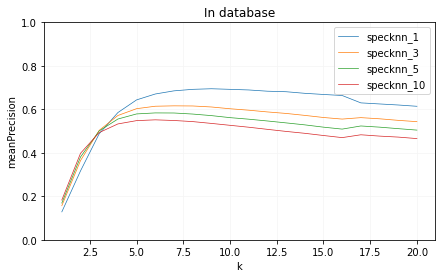

In [15]:
orderer_f = lambda x: int(x.split("_")[1])
hue_f = lambda x: [1,3,5,10].index(int(x.split("_")[1]))
plot_scores(scores, metrics="mpi",
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "k", ylabel="meanPrecision",
            save_to_path=f"figures/{kind}/selection/specknn_topk_val_prec.pdf")

In [16]:
best_p_name

'specknn_1'

## Visualisation of the best predictor

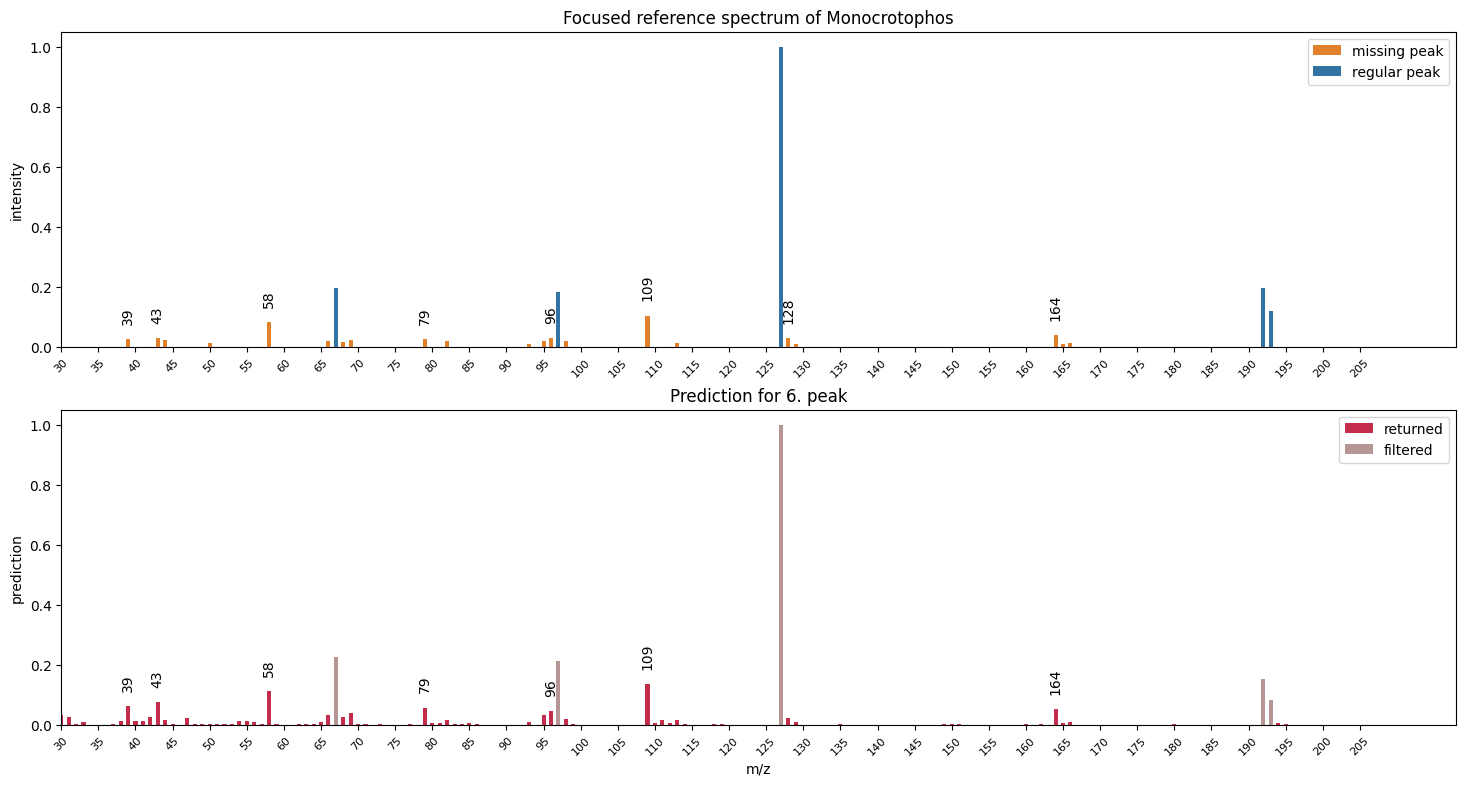

In [77]:
from visual_utils import plot_spectrum_predictions
i = 14047
k = 5
plotDS = TopKDS(documents_test, k=k, vocab={f"peak@{mz}": mz for mz in range(0,max_mz)}, onehot=False)
X = plotDS[i][0].numpy()
pred = predictors[best_p_name](compact_to_mz(X, max_mz))

plot_spectrum_predictions(documents_test[i], k, pred, BasicCoder(max_mz=max_mz),\
                            plot_full=False, \
                            save_to_path=f"figures/{kind}/visual/knn_test_topk.pdf")

In [ ]:
for i in range(len(documents_test)):
    if documents_test[i].metadata["name"] not in interesting:
        continue
    print(documents_test[i].metadata["name"])
    for k in [3,4,5,6,7,8]:
        plotDS = TopKDS(documents_test, k=k, vocab={f"peak@{mz}": mz for mz in range(0,max_mz)}, onehot=False)
        X = plotDS[i][0].numpy()
        pred = predictors[best_p_name](compact_to_mz(X, max_mz))

        plot_spectrum_predictions(documents_test[i], k, pred, BasicCoder(max_mz=max_mz),\
                                  plot_full=False, \
                                  save_to_path=f"figures/{kind}/visual/knn_test_{i}_top{k}.pdf")



## Evaluation on the test set

In [ ]:
%%time
up_to_k = 30
l = 20

calc_predictions(up_to_k, l, {best_p_name: predictors[best_p_name]}, datasets, \
                 "spec_test", P_FOLDER, verbose=False)

In [14]:
%%time
up_to_k = 30
l = 20

calc_predictions(up_to_k, l, {"specknn_3": predictors["specknn_3"]}, datasets, \
                 "spec_test", P_FOLDER, verbose=False)

specknn_3


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


CPU times: user 11h 39min 35s, sys: 2h 14min 32s, total: 13h 54min 8s
Wall time: 13h 54min 9s


In [17]:
best_p_name, scores_test = model_selection(P_FOLDER, "spec_test", predictors={best_p_name: predictors[best_p_name]}, up_to_k=30, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None)

specknn_1
Possible k up to 30, predict up to 20 peaks
Selected up to k=30, l=4, j=6
[22564 22564 22564 22564 22532 22501 22452 22410 22357 22280 22206 22125
 22020 21920 21801 21657 21522 21385 21218 21040 20846 20639 20440 20266
 20045 19857 19653 19446 19253 19029]
[22564 22564 22564 22564 22532 22501 22452 22410 22357 22280 22206 22125
 22020 21920 21801 21657 21522 21385 21218 21040 20846 20639 20440 20266
 20045 19857 19653 19446 19253 19029]
Selected up to k=30, l=None, to_rel_inten=0.2
[21122 22328 22520 22555 22561 22559 22562 22562 22563 22530 22501 22451
 22407 22354 22277 22205 22122 22016 21919 21799 21656 21519 21381 21214
 21040 20846 20638 20437 20264 20044]
[21122 22328 22520 22555 22561 22559 22562 22562 22563 22530 22501 22451
 22407 22354 22277 22205 22122 22016 21919 21799 21656 21519 21381 21214
 21040 20846 20638 20437 20264 20044]


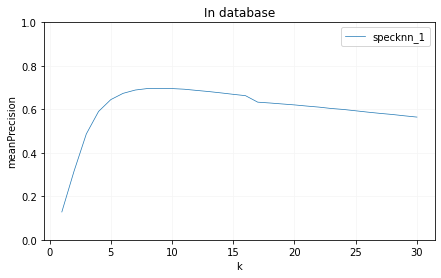

In [18]:
orderer_f = lambda x: int(x.split("_")[1])
hue_f = lambda x: [1,3,5,10].index(int(x.split("_")[1]))
plot_scores(scores_test, metrics="mpi",
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "k", ylabel="meanPrecision",
            save_to_path=f"figures/{kind}/selection/specknn_topk_test_prec.pdf")

# Missing random

In [12]:
predictors = { "specknnR_1_.5" :BasePredictorKNN(mz_matrix_train, sparse_weighted_mz_matrix, sparse_mz_matrix, 1, above_fraction=.5),
               "specknnR_3_.5" :BasePredictorKNN(mz_matrix_train,sparse_weighted_mz_matrix, sparse_mz_matrix, 3, above_fraction=.5), 
               "specknnR_10_.5": BasePredictorKNN(mz_matrix_train,sparse_weighted_mz_matrix, sparse_mz_matrix, 10, above_fraction=.5),
               "specknnR_1_.8" :BasePredictorKNN(mz_matrix_train,sparse_weighted_mz_matrix, sparse_mz_matrix, 1, above_fraction=.8),
               "specknnR_3_.8" :BasePredictorKNN(mz_matrix_train,sparse_weighted_mz_matrix, sparse_mz_matrix, 3, above_fraction=.8), 
               "specknnR_10_.8": BasePredictorKNN(mz_matrix_train,sparse_weighted_mz_matrix, sparse_mz_matrix, 10, above_fraction=.8),
               "specknnR_1_.1" :BasePredictorKNN(mz_matrix_train,sparse_weighted_mz_matrix, sparse_mz_matrix, 1, above_fraction=0.1),
               "specknnR_3_.1" :BasePredictorKNN(mz_matrix_train,sparse_weighted_mz_matrix, sparse_mz_matrix, 3, above_fraction=0.1), 
               "specknnR_10_.1": BasePredictorKNN(mz_matrix_train,sparse_weighted_mz_matrix, sparse_mz_matrix, 10, above_fraction=0.1),
               "specknnR_1_.2" :BasePredictorKNN(mz_matrix_train,sparse_weighted_mz_matrix, sparse_mz_matrix, 1, above_fraction=0.2),
               "specknnR_3_.2" :BasePredictorKNN(mz_matrix_train,sparse_weighted_mz_matrix, sparse_mz_matrix, 3, above_fraction=0.2), 
               "specknnR_10_.2": BasePredictorKNN(mz_matrix_train,sparse_weighted_mz_matrix, sparse_mz_matrix, 10, above_fraction=0.2)
             }

P_FOLDER = f"predictions/{kind}"

probs = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]

In [13]:
from model_evaluation import calc_predictions_random, load_predictions_random, model_selection_random

In [14]:
%%time
calc_predictions_random(probs, predictors, datasets, "spec_val_5000", P_FOLDER, cum_level=.95, verbose=False)

specknnR_1_.5


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


specknnR_3_.5
specknnR_10_.5
specknnR_1_.8
specknnR_3_.8
specknnR_10_.8
specknnR_1_.1
specknnR_3_.1
specknnR_10_.1
specknnR_1_.2
specknnR_3_.2
specknnR_10_.2
CPU times: user 1d 5h 15min 39s, sys: 36min 17s, total: 1d 5h 51min 57s
Wall time: 9h 10min 23s


In [15]:
best_p_name_random, scores_random = model_selection_random(P_FOLDER, "spec_val_5000", \
                                                           predictors=predictors)
# plot_scores(scores_random, metrics="mf1")

specknnR_1_.5


/auto/brno6/home/xstary1/raims/metrics.py:232: RuntimeWarning: Mean of empty slice
  "mp": np.nanmean(recs_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:234: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:235: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


specknnR_1_.1
specknnR_10_.5
specknnR_3_.2
specknnR_10_.2
specknnR_1_.8
specknnR_10_.1
specknnR_3_.1
specknnR_3_.8
specknnR_1_.2
specknnR_3_.5
specknnR_10_.8


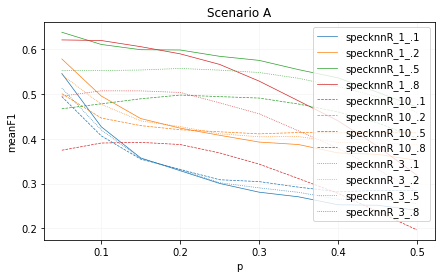

In [16]:
orderer_f = lambda x: (x.split("_")[1], float(x.split("_")[2]))
hue_f = lambda x: [".1", ".2", ".5",".8","1","1.2"].index(x.split("_")[2])
plot_scores(scores_random, metrics="mf1", x=probs,
            orderer_f=orderer_f,hue_f=hue_f, grouper_f=lambda x: x.split("_")[1],
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanF1",
            save_to_path=f"figures/{kind}/selection/specknn_random_val_f1.pdf")

In [17]:
best_p_name_random

'specknnR_1_.5'

## Visualisation of the best predictor

Carbofuran


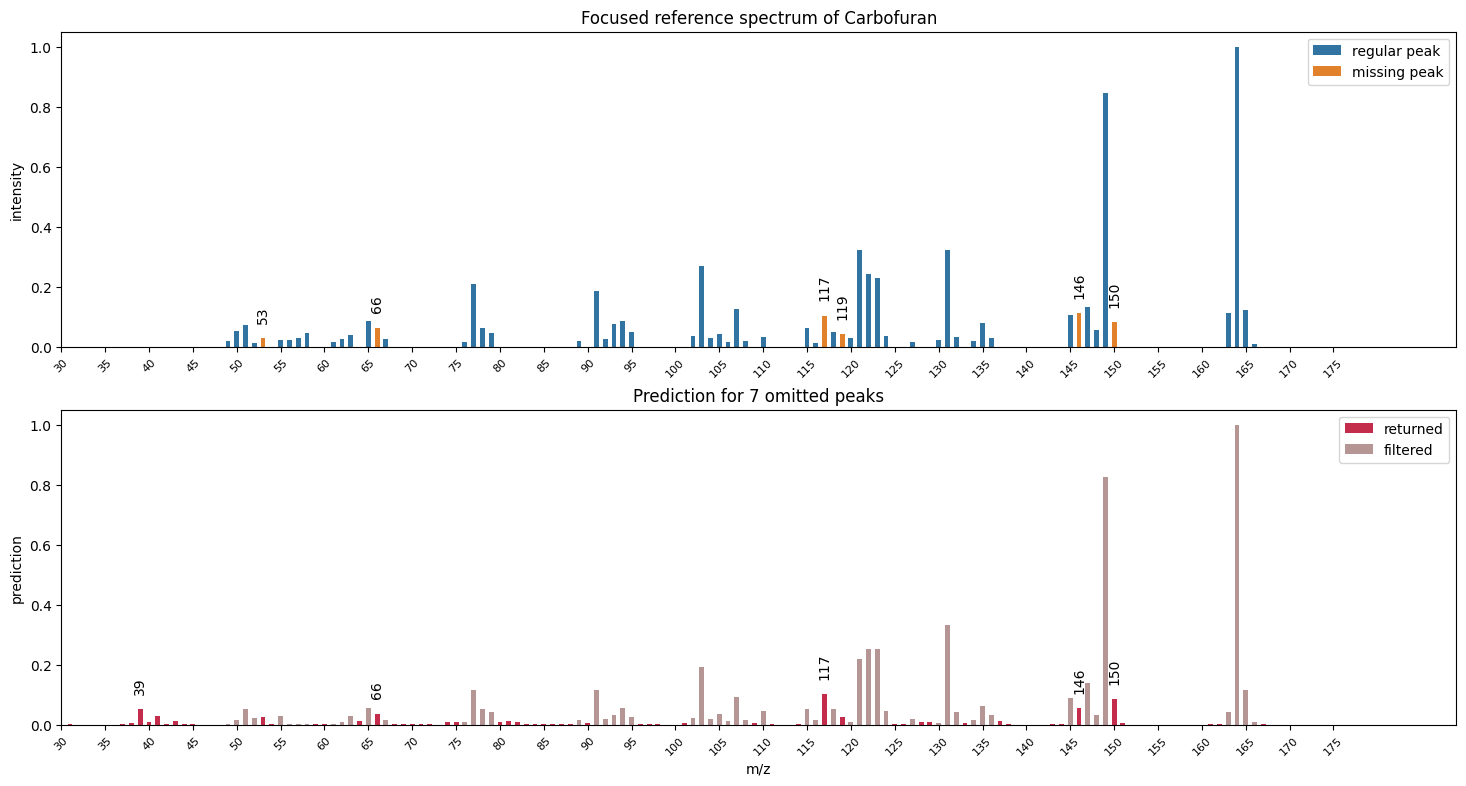

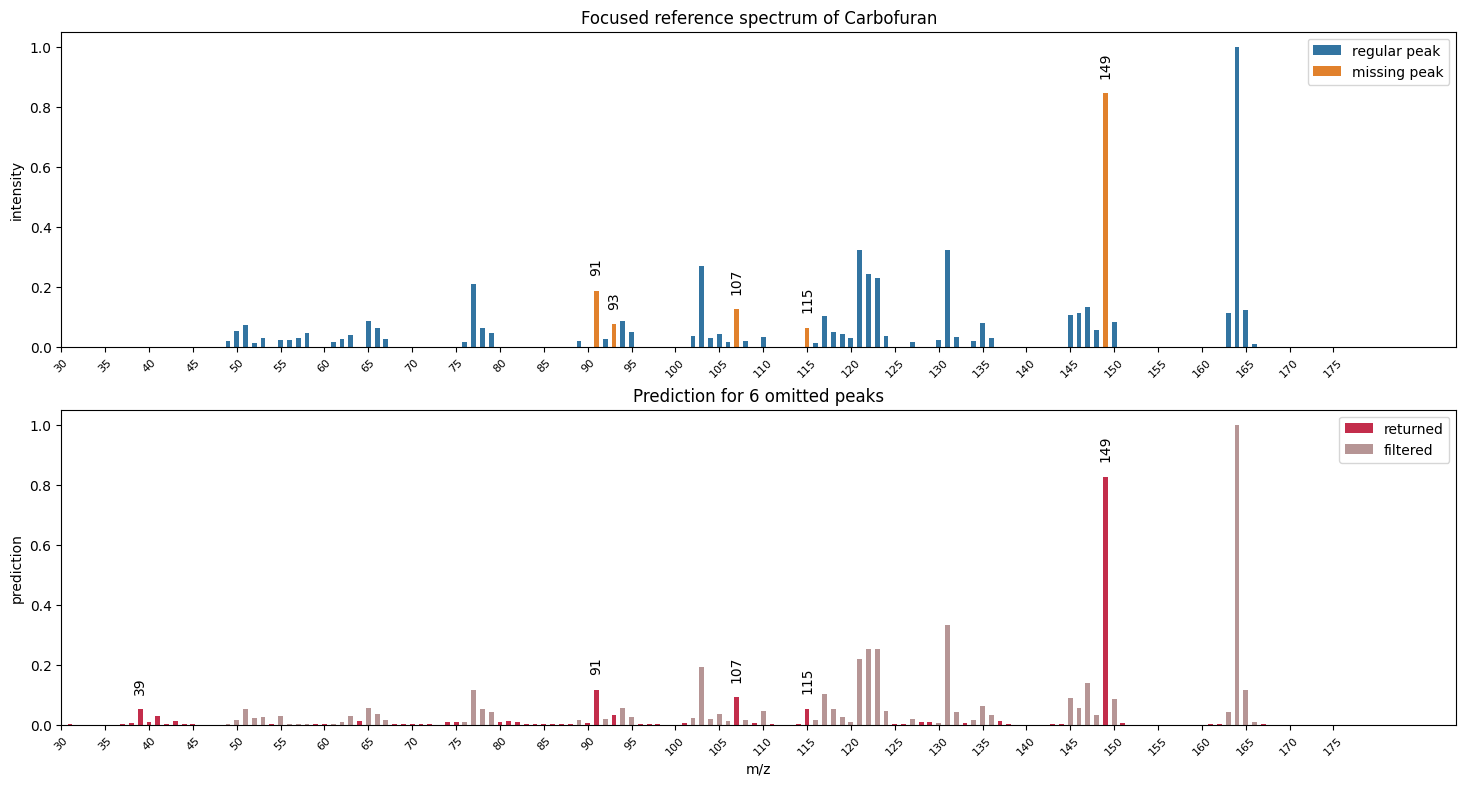

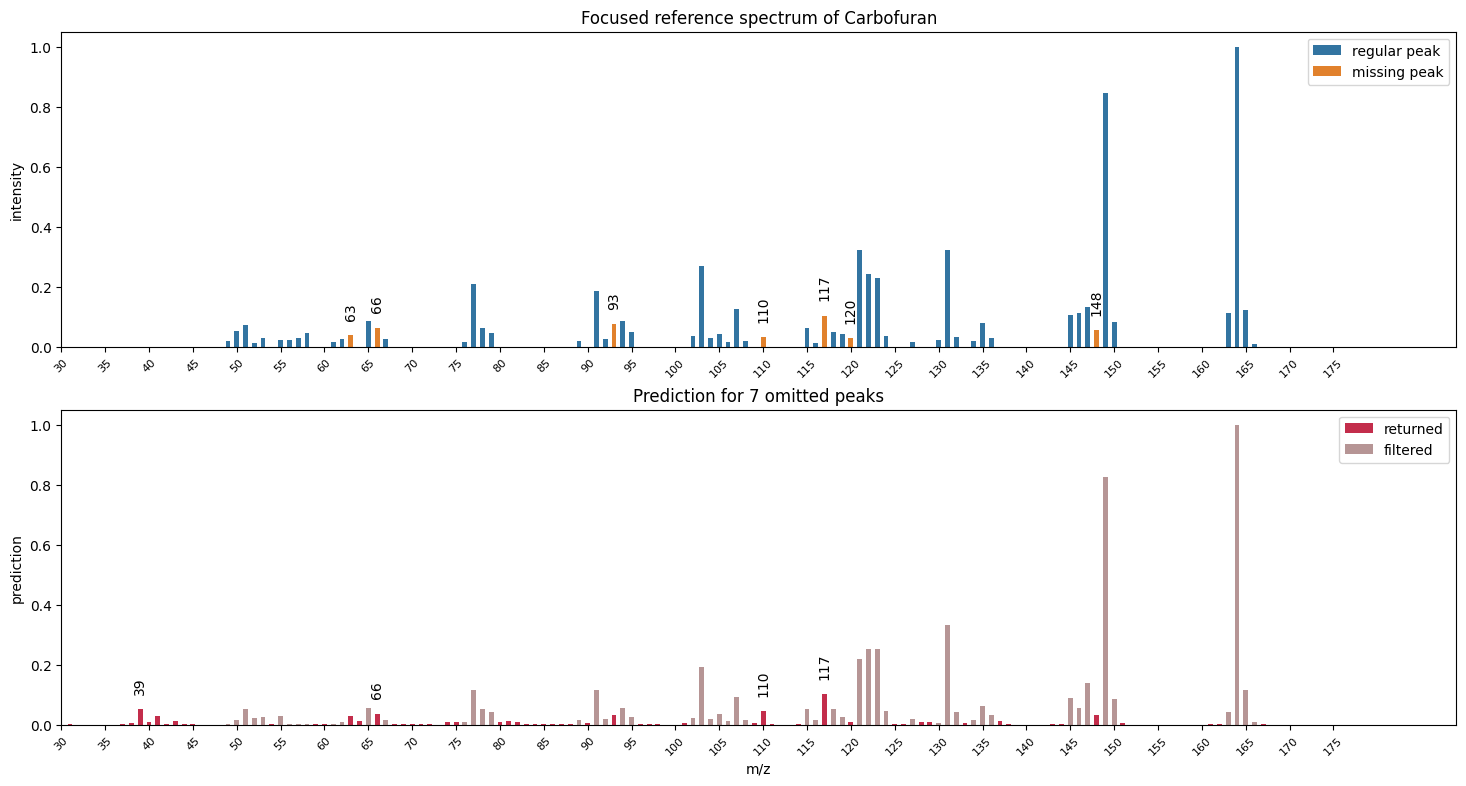

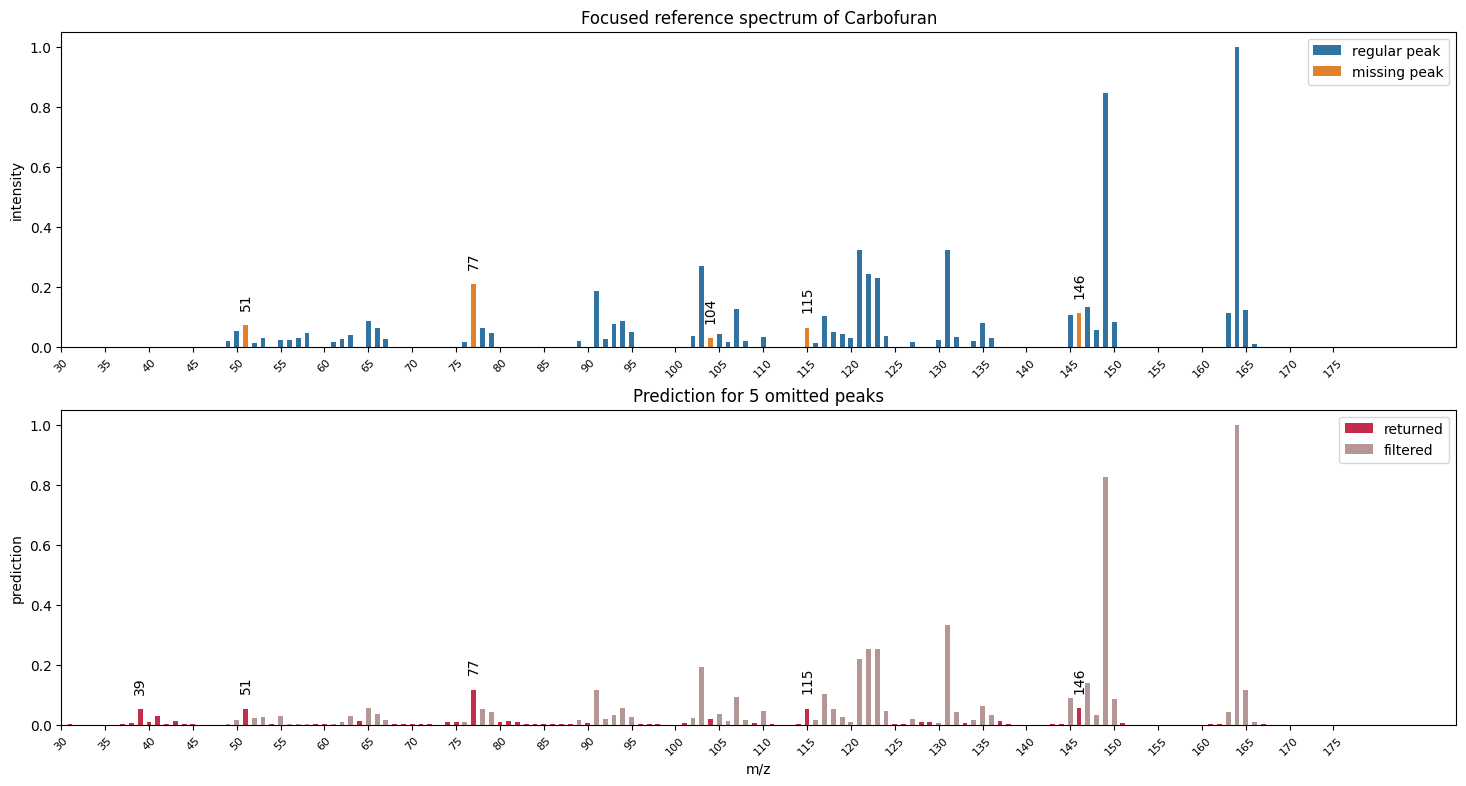

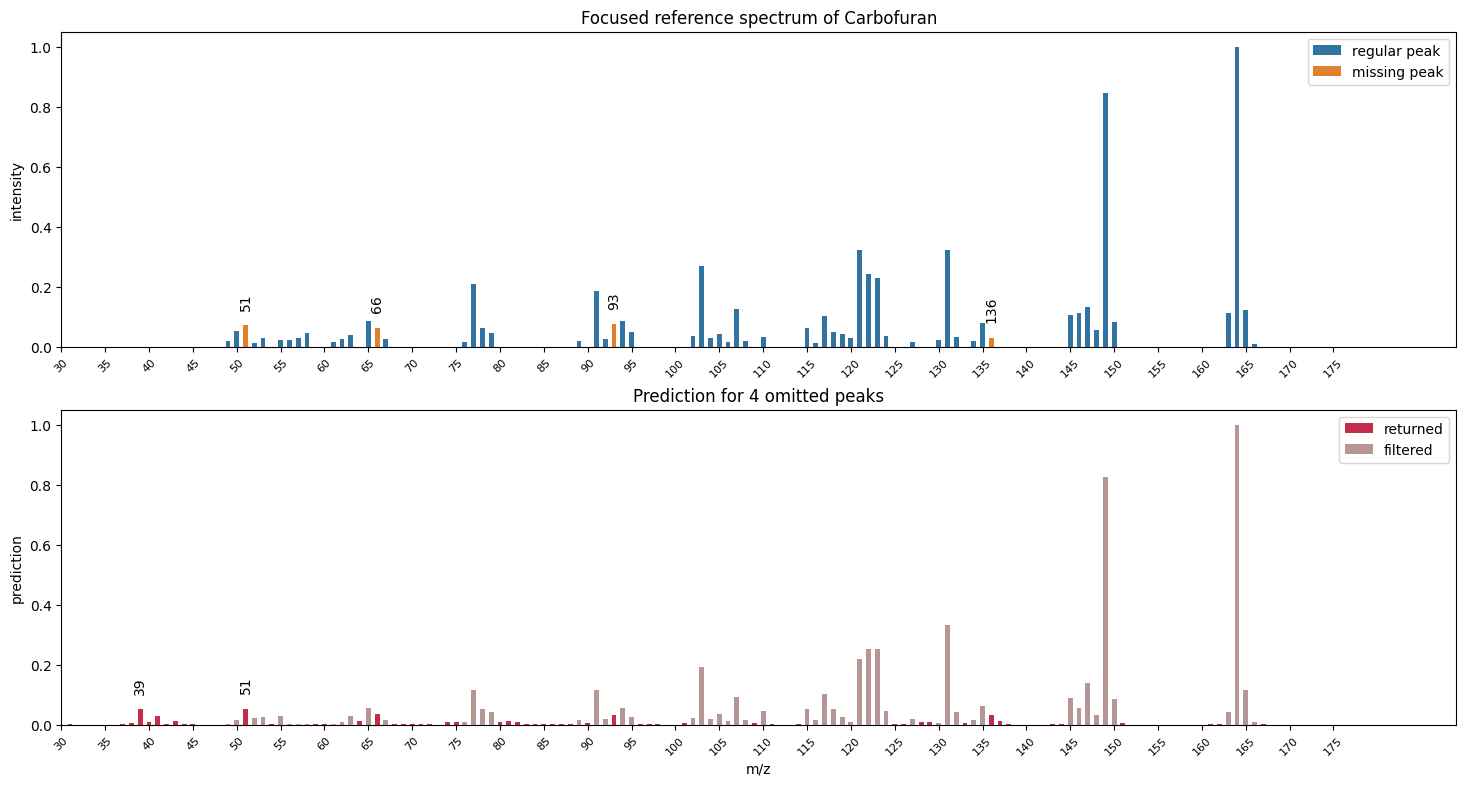

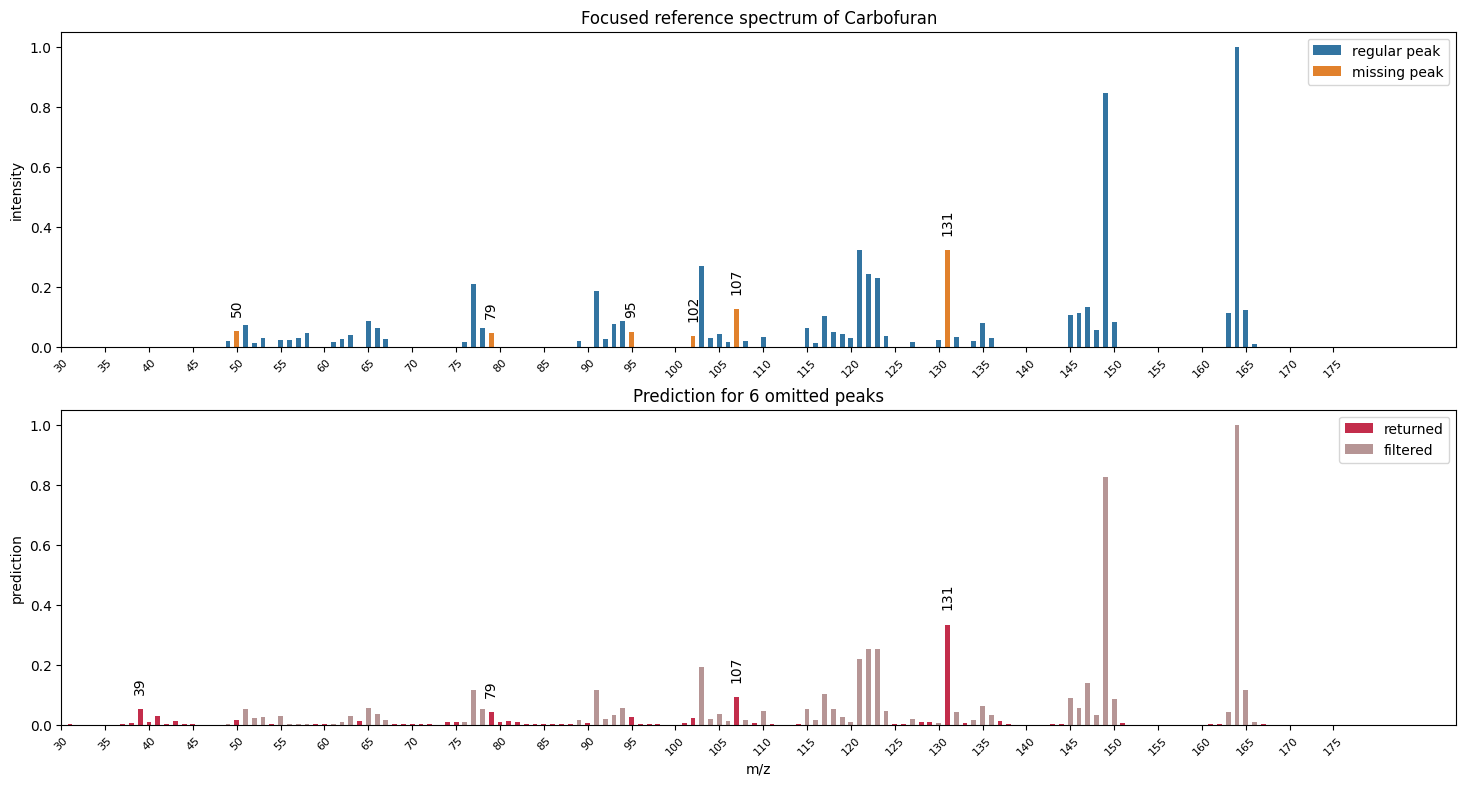

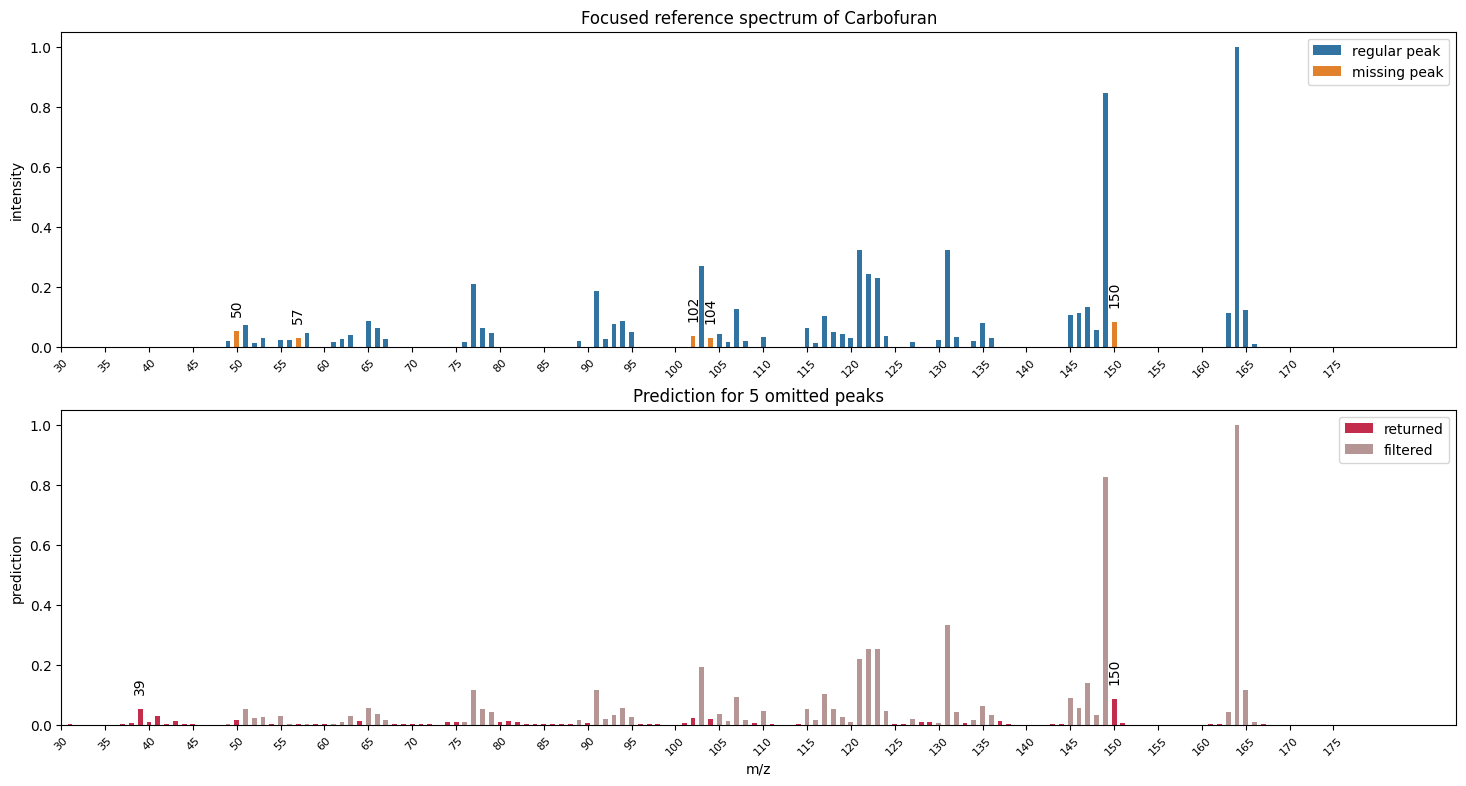

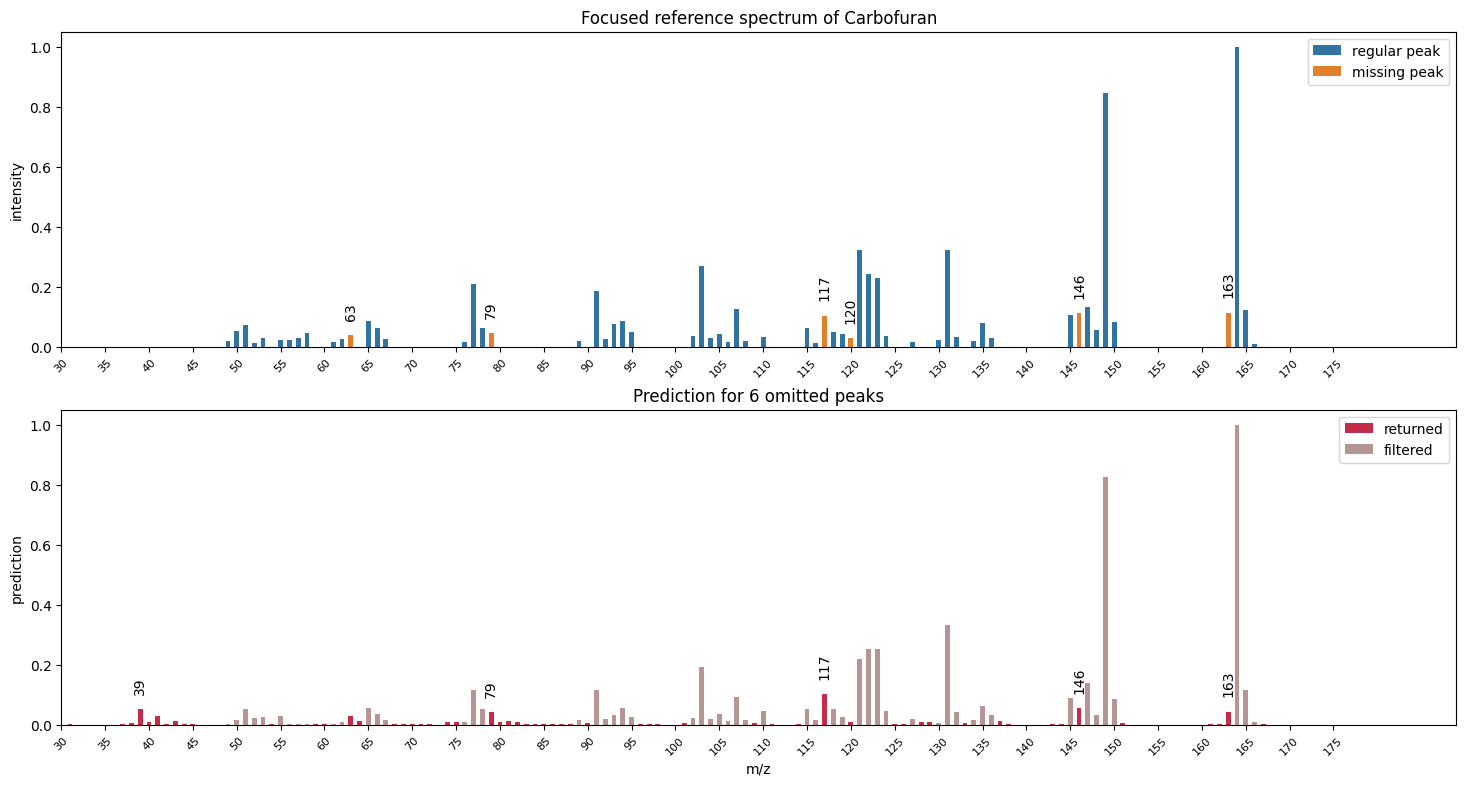

In [18]:
from visual_utils import plot_spectrum_predictions_random
for i in range(len(documents_test)):
    if i != 13766:
        continue
    if documents_test[i].metadata["name"] not in interesting:
        continue
    print(documents_test[i].metadata["name"])
    for seed in range(8):
        
        

        datasets["fixed_test"].reset_rng(seed)
        X, y = datasets["fixed_test"][i]
        pred = predictors[best_p_name_random](X.numpy())
        
        peaks = predictors[best_p_name_random].get_peaks_above(pred, X.numpy(),  cum_level=0.95)
        plot_spectrum_predictions_random(documents_test[i], np.where(y!=0)[0], pred, \
                                         BasicCoder(max_mz=max_mz), plot_full=False, predicted_peaks=peaks,
                                         save_to_path=f"figures/{kind}/visual/knn_test_{i}_random{seed}.pdf")


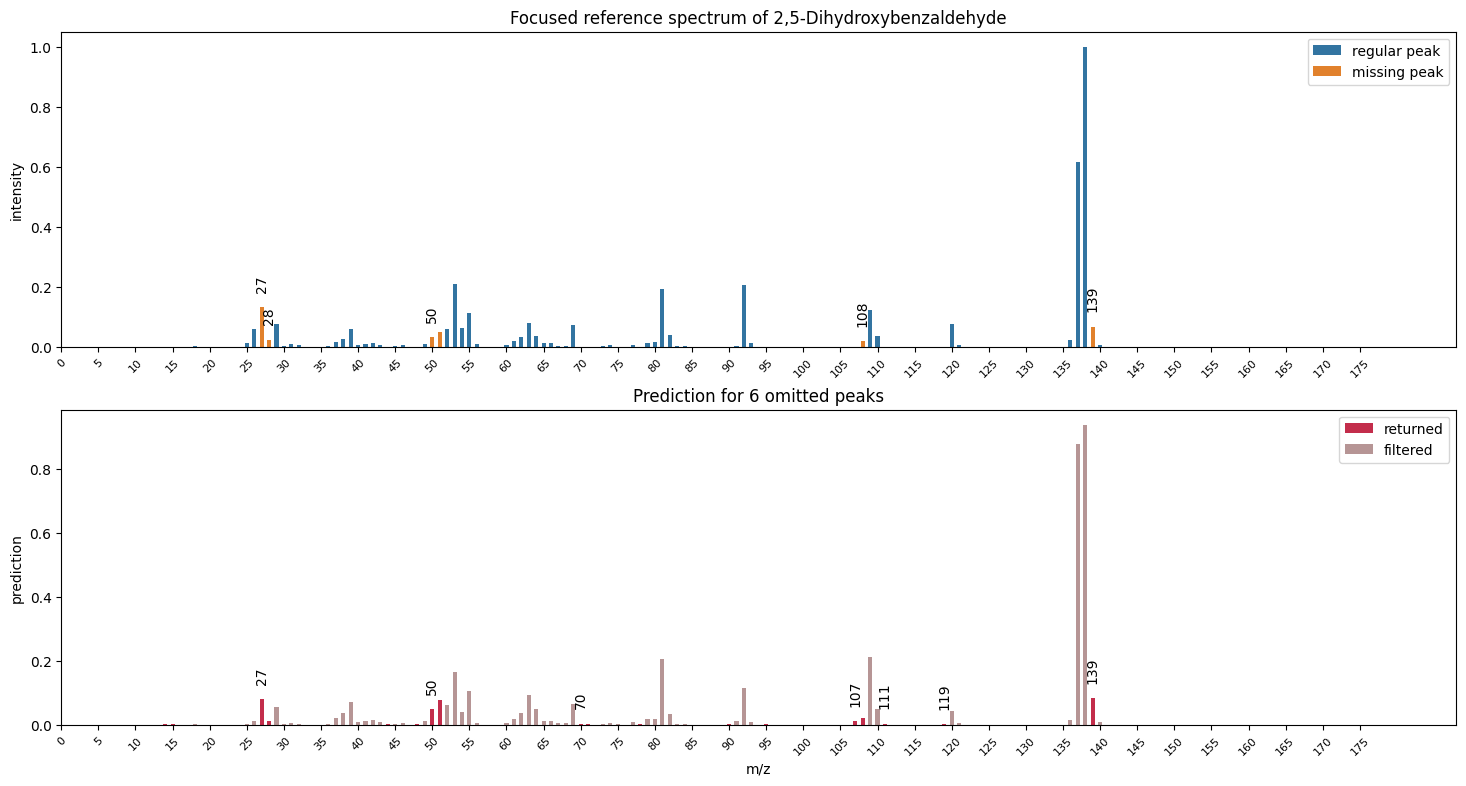

In [81]:
i  = 4444
datasets["fixed_test"].reset_rng(42)
X, y = datasets["fixed_test"][i]
pred = predictors[best_p_name_random](X.numpy())
plot_spectrum_predictions_random(documents_test[i], np.where(y!=0)[0], pred, \
                                 BasicCoder(max_mz=max_mz), plot_full=False,
                                 save_to_path=f"figures/{kind}/visual/knn_random_test.pdf")


## Evaluation on the test set

In [19]:
%%time

calc_predictions_random(probs, {best_p_name_random: predictors[best_p_name_random]}, datasets, "spec_test", P_FOLDER, \
                        cum_level=.95, verbose=False)

specknnR_1_.5


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


CPU times: user 10h 56min 52s, sys: 13min 51s, total: 11h 10min 43s
Wall time: 3h 22min 11s


In [20]:
best_p_name_random, scores_random_test = model_selection_random(P_FOLDER, "spec_test", \
                                                           predictors={best_p_name_random: predictors[best_p_name_random]})


specknnR_1_.5


/auto/brno6/home/xstary1/raims/metrics.py:232: RuntimeWarning: Mean of empty slice
  "mp": np.nanmean(recs_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:234: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:235: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


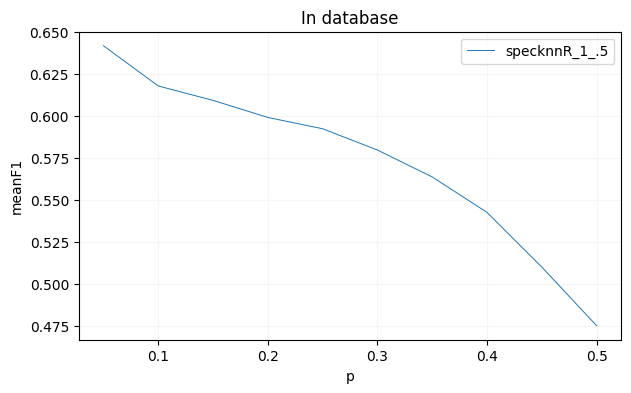

In [21]:
orderer_f = lambda x: (x.split("_")[1], float(x.split("_")[2]))
hue_f = lambda x: [".5",".8","1","1.2"].index(x.split("_")[2])
plot_scores(scores_random_test, metrics="mf1", x=probs,
            orderer_f=orderer_f,hue_f=hue_f, grouper_f=lambda x: x.split("_")[1],
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1",
            save_to_path=f"figures/{kind}/selection/specknn_random_test_f1.pdf")